# Stabilne Skojarzenia – Algorytm Gale’a-Shapleya

Ten notebook prezentuje implementację algorytmu Gale’a-Shapleya dla problemu stabilnych skojarzeń.

Rozważamy dwie grupy: A i B, gdzie każdy element ma uporządkowane preferencje wobec członków drugiej grupy. Celem algorytmu jest znalezienie stabilnego skojarzenia, czyli takiego, w którym nie istnieje para osób, która wolałaby siebie nawzajem bardziej niż swoje obecne dopasowanie.

## Import pakietów

In [1]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Klasa StabilneSkojarzenia

Poniżej definiujemy klasę, która:

- przyjmuje dwie grupy wierzchołków A i B,
- umożliwia ręczne lub losowe ustawienie preferencji,
- rozwiązuje problem skojarzeń przy użyciu algorytmu Gale’a-Shapleya,
- drukuje preferencje i wyniki,
- wizualizuje skojarzenie,
- oblicza średni poziom zadowolenia z grup,
- wizualizuje poziomy zadowolenia.

In [2]:
class StabilneSkojarzenia:
    def __init__(self, n):
        self.A = [f"A{i}" for i in range(n)]
        self.B = [f"B{i}" for i in range(n)]
        self.A_prefs = {}
        self.B_prefs = {}
        self.matching_A = {}
        self.matching_B = {}

    def set_preferences(self, A_prefs, B_prefs):
        self.A_prefs = A_prefs
        self.B_prefs = B_prefs

    def generate_random_preferences(self):
        self.A_prefs = {a: random.sample(self.B, len(self.B)) for a in self.A}
        self.B_prefs = {b: random.sample(self.A, len(self.A)) for b in self.B}

    def solve_A(self):
        free_A = list(self.A)
        engaged = {}
        proposals = {a: [] for a in self.A}

        B_rank = {b: {a: i for i, a in enumerate(pref)} for b, pref in self.B_prefs.items()}

        while free_A:
            a = free_A.pop(0)
            for b in self.A_prefs[a]:
                if b not in proposals[a]:
                    proposals[a].append(b)
                    if b not in engaged:
                        engaged[b] = a
                        break
                    else:
                        current_a = engaged[b]
                        if B_rank[b][a] < B_rank[b][current_a]:
                            engaged[b] = a
                            free_A.append(current_a)
                            break

        self.matching_A = {a: b for b, a in engaged.items()}

    def solve_B(self):
        free_B = list(self.B)
        engaged = {}
        proposals = {b: [] for b in self.B}
        A_rank = {a: {b: i for i, b in enumerate(pref)} for a, pref in self.A_prefs.items()}

        while free_B:
            b = free_B.pop(0)
            for a in self.B_prefs[b]:
                if a not in proposals[b]:
                    proposals[b].append(a)
                    if a not in engaged:
                        engaged[a] = b
                        break
                    else:
                        current_b = engaged[a]
                        if A_rank[a][b] < A_rank[a][current_b]:
                            engaged[a] = b
                            free_B.append(current_b)
                            break

        self.matching_B = {a: b for a, b in engaged.items()}

    def print_preferences(self):
        print("Preferencje A:")
        for a in self.A:
            print(f"{a}: {self.A_prefs[a]}")

        print("\nPreferencje B:")
        for b in self.B:
            print(f"{b}: {self.B_prefs[b]}")

    def print_matching(self, matching_type='A'):
        def sort_key(name):
          return int(name[1:])

        if matching_type == 'A':
            matching = self.matching_A
            print("Stabilne skojarzenie optymalne dla A:")
            for a in sorted(matching.keys(), key=sort_key):
                print(f"{a} ⟶ {matching[a]}")

        elif matching_type == 'B':
            matching = self.matching_B
            print("Stabilne skojarzenie optymalne dla B:")
            reverse_matching = {b: a for a, b in matching.items()}
            for b in sorted(reverse_matching.keys(), key=sort_key):
                print(f"{b} ⟶ {reverse_matching[b]}")

        else:
            print("Użyj 'A' lub 'B'")


    def visualize(self, matching_type='A'):
        def sort_key(name):
            return int(name[1:])

        G = nx.Graph()
        G.add_nodes_from(self.A, bipartite=0)
        G.add_nodes_from(self.B, bipartite=1)

        for a in self.A:
            for b in self.B:
                G.add_edge(a, b)

        pos = {}
        if matching_type == 'A':
            for i, a in enumerate(sorted(self.A, key=sort_key)):
                pos[a] = (0, -i)
            for i, b in enumerate(sorted(self.B, key=sort_key)):
                pos[b] = (1, -i)

            title = "Stabilne skojarzenie optymalne dla A"

        elif matching_type == 'B':
            for i, b in enumerate(sorted(self.B, key=sort_key)):
                pos[b] = (0, -i)
            for i, a in enumerate(sorted(self.A, key=sort_key)):
                pos[a] = (1, -i)

            title = "Stabilne skojarzenie optymalne dla B"

        else:
            print("Użyj 'A' lub 'B'")
            return

        plt.figure(figsize=(8, 6))
        nx.draw_networkx_edges(G, pos, alpha=0.2)

        if matching_type == 'A':
            matching = self.matching_A
        else:
            matching = self.matching_B

        matching_edges = [(a, b) for a, b in matching.items()]
        nx.draw_networkx_edges(G, pos, edgelist=matching_edges, edge_color='red', width=2)

        nx.draw_networkx_nodes(G, pos, nodelist=self.A, node_color='skyblue')
        nx.draw_networkx_nodes(G, pos, nodelist=self.B, node_color='lightgreen')
        nx.draw_networkx_labels(G, pos)

        plt.title(title)
        plt.axis('off')
        plt.show()

    def satisfaction_score(self, matching, for_group='A'):
        """
        Średni poziom zadowolenia grup to miara pokazująca, jak zadowoleni są członkowie danej grupy z otrzymanych partnerów w dopasowaniu.
        Im wyższy wynik, tym mniejsze zadowolenie grupy.
        Najlepszy możliwy wynik: 1 (wszyscy dostali swoje pierwsze wybory)
        Maksymalna wartość to: n (liczba osób w grupie)
        """
        total_score = 0
        count = 0
        for a, b in matching.items():
            if for_group == 'A':
                prefs = self.A_prefs[a]
                matched = b
            else:
                prefs = self.B_prefs[b]
                matched = a

            score = prefs.index(matched) + 1
            total_score += score
            count += 1

        return total_score / count if count > 0 else 0

    def visualize_satisfaction(self, matching_type='A'):

        if matching_type == 'A':
            matching = self.matching_A
            title = "Poziom zadowolenia grupy A"
            group = self.A
            prefs = self.A_prefs
            labels = sorted(group, key=lambda x: int(x[1:]))
            scores = [prefs[a].index(matching[a]) + 1 for a in labels]
        elif matching_type == 'B':
            matching = self.matching_B
            title = "Poziom zadowolenia grupy B"
            group = self.B
            prefs = self.B_prefs
            reverse_matching = {b: a for a, b in matching.items()}
            labels = sorted(group, key=lambda x: int(x[1:]))
            scores = [prefs[b].index(reverse_matching[b]) + 1 for b in labels]
        else:
            print("Użyj 'A' lub 'B' jako argumentu.")
            return

        avg_score = sum(scores) / len(scores)

        plt.figure(figsize=(10, 5))
        bars = plt.bar(labels, scores, color='lightgreen')
        plt.axhline(avg_score, color='blue', linestyle='--', label=f'Średnia = {avg_score:.2f}')
        plt.ylabel('Pozycja wybranego partnera na liście preferencji')
        plt.title(title)
        plt.legend()
        plt.ylim(0.5, max(scores) + 1)
        plt.grid(axis='y', linestyle=':', alpha=0.6)
        plt.tight_layout()
        plt.show()


## Sposób użycia

Tworzymy przykładowe grupy A i B, wybieramy lub losujemy preferencje i rozwiązujemy problem skojarzeń.

- preferencje dodawane przez użytkownika

In [3]:
A_prefs = {
    'A0': ['B1', 'B2', 'B3', 'B0'],
    'A1': ['B1', 'B3', 'B2', 'B0'],
    'A2': ['B3', 'B0', 'B1', 'B2'],
    'A3': ['B2', 'B1', 'B0', 'B3']
}

B_prefs = {
    'B0': ['A1', 'A3', 'A0', 'A2'],
    'B1': ['A1', 'A0', 'A3', 'A2'],
    'B2': ['A1', 'A2', 'A0', 'A3'],
    'B3': ['A0', 'A2', 'A1', 'A3']
}

ss = StabilneSkojarzenia(4)
ss.set_preferences(A_prefs, B_prefs)
ss.print_preferences()

Preferencje A:
A0: ['B1', 'B2', 'B3', 'B0']
A1: ['B1', 'B3', 'B2', 'B0']
A2: ['B3', 'B0', 'B1', 'B2']
A3: ['B2', 'B1', 'B0', 'B3']

Preferencje B:
B0: ['A1', 'A3', 'A0', 'A2']
B1: ['A1', 'A0', 'A3', 'A2']
B2: ['A1', 'A2', 'A0', 'A3']
B3: ['A0', 'A2', 'A1', 'A3']


Stabilne skojarzenie optymalne dla A:
A0 ⟶ B2
A1 ⟶ B1
A2 ⟶ B3
A3 ⟶ B0


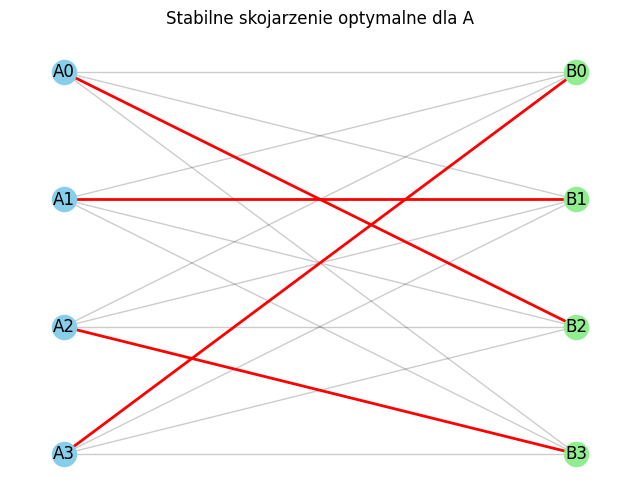

In [4]:
ss.solve_A()
ss.print_matching('A')
ss.visualize('A')

Średni poziom zadowolenia grupy A: 1.75


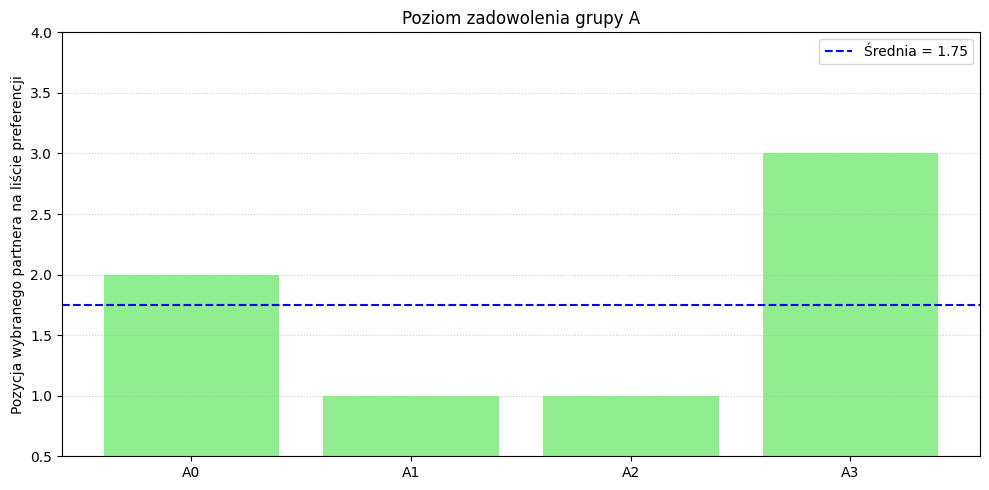

In [5]:
print("Średni poziom zadowolenia grupy A:", ss.satisfaction_score(ss.matching_A, for_group='A'))
ss.visualize_satisfaction('A')

Stabilne skojarzenie optymalne dla B:
B0 ⟶ A3
B1 ⟶ A1
B2 ⟶ A2
B3 ⟶ A0


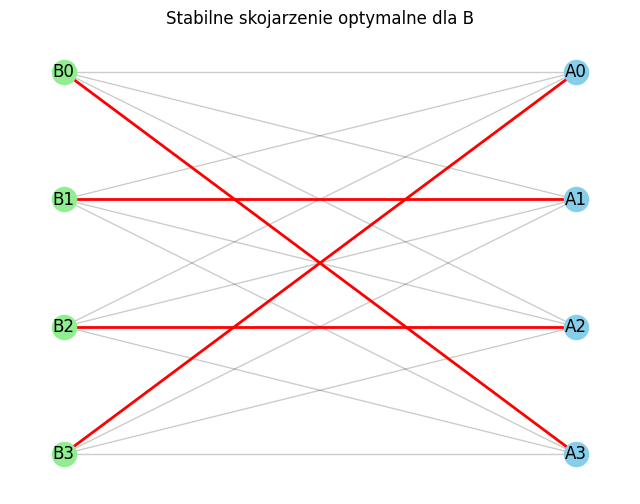

In [6]:
ss.solve_B()
ss.print_matching('B')
ss.visualize('B')

Średni poziom zadowolenia grupy B: 1.5


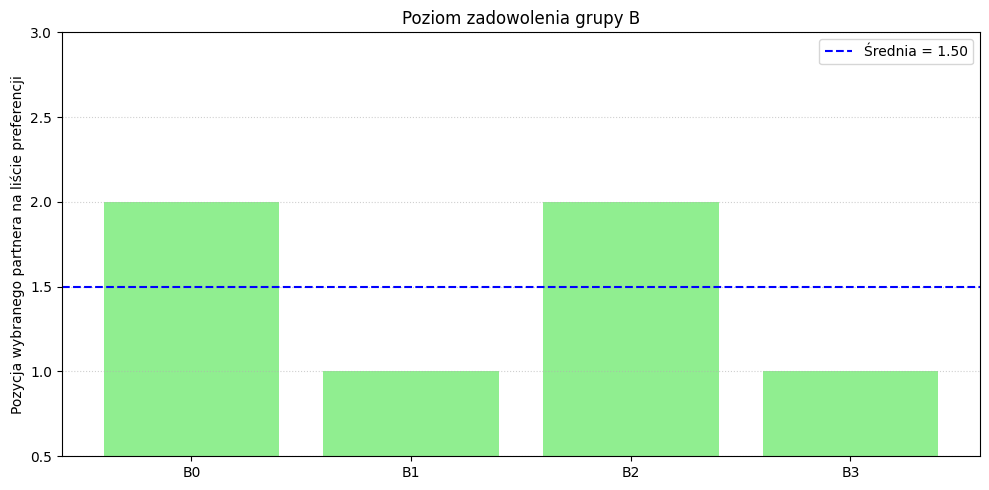

In [7]:
print("Średni poziom zadowolenia grupy B:", ss.satisfaction_score(ss.matching_B, for_group='B'))
ss.visualize_satisfaction('B')

- preferencje generowane losowo

In [8]:
ss = StabilneSkojarzenia(10)
ss.generate_random_preferences()
ss.print_preferences()

Preferencje A:
A0: ['B9', 'B6', 'B5', 'B2', 'B4', 'B7', 'B8', 'B3', 'B1', 'B0']
A1: ['B0', 'B3', 'B8', 'B5', 'B2', 'B6', 'B9', 'B4', 'B7', 'B1']
A2: ['B8', 'B9', 'B2', 'B3', 'B4', 'B5', 'B1', 'B6', 'B7', 'B0']
A3: ['B6', 'B5', 'B9', 'B4', 'B7', 'B0', 'B8', 'B1', 'B3', 'B2']
A4: ['B4', 'B8', 'B6', 'B1', 'B0', 'B7', 'B2', 'B3', 'B5', 'B9']
A5: ['B2', 'B7', 'B6', 'B3', 'B9', 'B5', 'B4', 'B8', 'B1', 'B0']
A6: ['B1', 'B9', 'B6', 'B2', 'B0', 'B5', 'B8', 'B4', 'B7', 'B3']
A7: ['B9', 'B0', 'B2', 'B1', 'B6', 'B7', 'B8', 'B4', 'B3', 'B5']
A8: ['B9', 'B5', 'B8', 'B1', 'B0', 'B2', 'B6', 'B7', 'B4', 'B3']
A9: ['B9', 'B8', 'B4', 'B5', 'B7', 'B2', 'B3', 'B1', 'B6', 'B0']

Preferencje B:
B0: ['A4', 'A9', 'A1', 'A7', 'A8', 'A6', 'A2', 'A0', 'A5', 'A3']
B1: ['A1', 'A0', 'A9', 'A6', 'A3', 'A5', 'A2', 'A8', 'A7', 'A4']
B2: ['A9', 'A4', 'A1', 'A7', 'A5', 'A8', 'A6', 'A2', 'A3', 'A0']
B3: ['A2', 'A6', 'A3', 'A8', 'A9', 'A4', 'A0', 'A7', 'A1', 'A5']
B4: ['A7', 'A9', 'A0', 'A5', 'A8', 'A1', 'A6', 'A2', 'A4', 

Stabilne skojarzenie optymalne dla A:
A0 ⟶ B4
A1 ⟶ B3
A2 ⟶ B8
A3 ⟶ B5
A4 ⟶ B0
A5 ⟶ B6
A6 ⟶ B1
A7 ⟶ B2
A8 ⟶ B7
A9 ⟶ B9


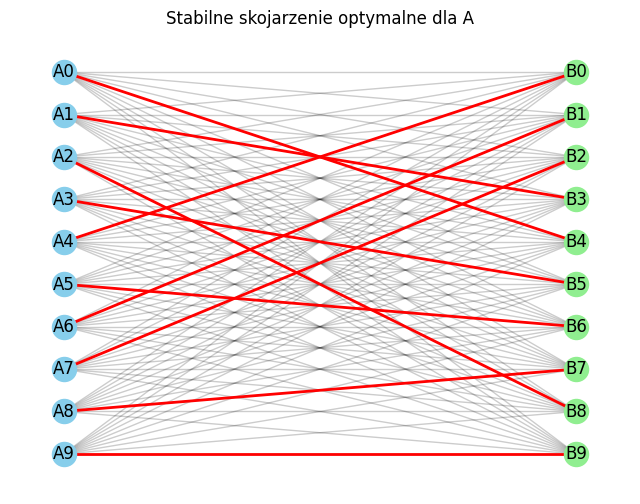

In [9]:
ss.solve_A()
ss.print_matching('A')
ss.visualize('A')

Średni poziom zadowolenia grupy A: 3.1


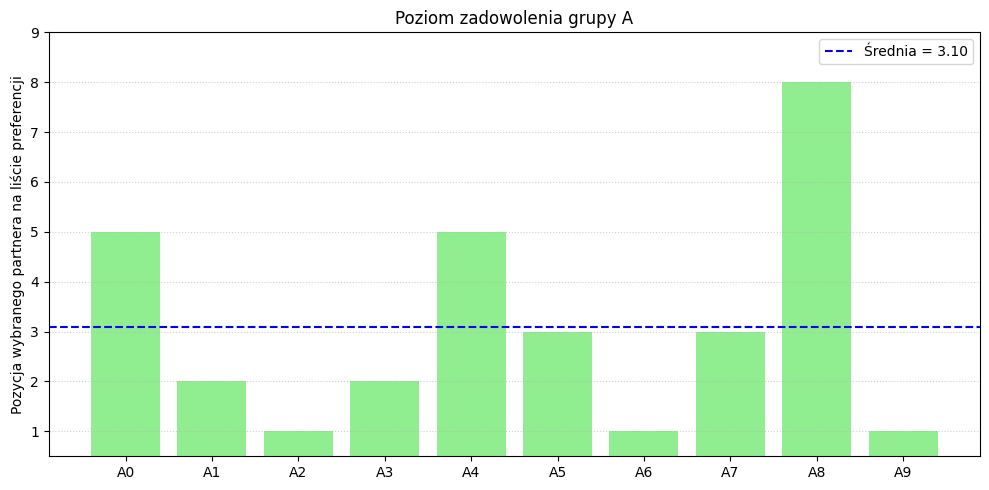

In [10]:
print("Średni poziom zadowolenia grupy A:", ss.satisfaction_score(ss.matching_A, for_group='A'))
ss.visualize_satisfaction('A')

Stabilne skojarzenie optymalne dla B:
B0 ⟶ A4
B1 ⟶ A6
B2 ⟶ A7
B3 ⟶ A2
B4 ⟶ A0
B5 ⟶ A3
B6 ⟶ A5
B7 ⟶ A8
B8 ⟶ A1
B9 ⟶ A9


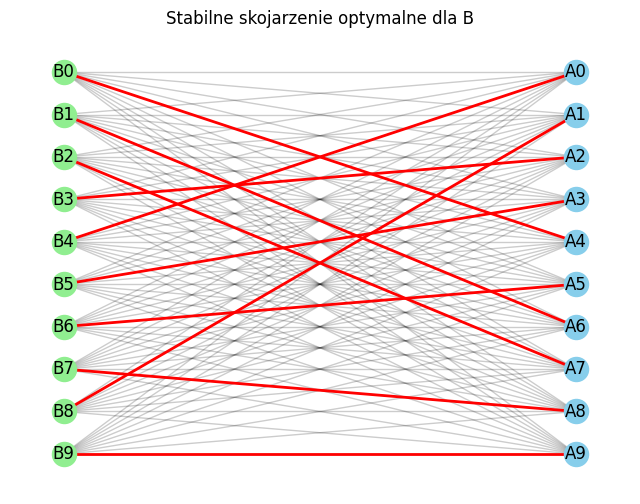

In [11]:
ss.solve_B()
ss.print_matching('B')
ss.visualize('B')

Średni poziom zadowolenia grupy B: 2.6


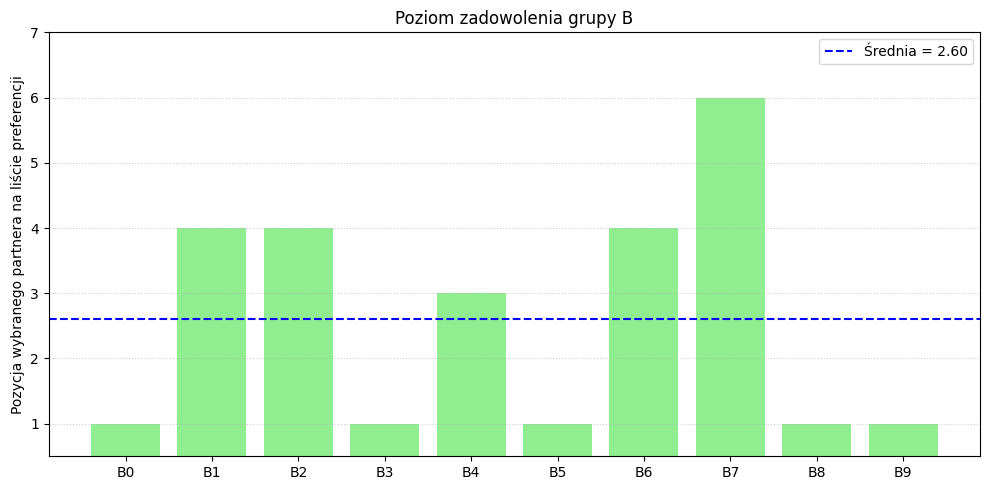

In [12]:
print("Średni poziom zadowolenia grupy B:", ss.satisfaction_score(ss.matching_B, for_group='B'))
ss.visualize_satisfaction('B')